In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pickle as pkl

torch.manual_seed(100)
torch.cuda.manual_seed(100)
np.random.seed(100)
random.seed(100)

/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Initial analysis

In [2]:
if torch.cuda.is_available():
    rank = 0
    torch.cuda.set_device(rank)
    current_device = torch.device("cuda", rank)
else:
    current_device = torch.device("cpu")


In [3]:
actual_test_data = pd.read_csv('test.csv')
actual_test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [4]:
VAL_DATE = '2015-05-08'
TEST_DATE = '2015-06-20'

In [5]:
data = pd.read_csv('train.csv', low_memory=False)

In [6]:
store_data = pd.read_csv('store.csv')

In [7]:
full_data = data.merge(store_data, on='Store')
full_data = full_data.sort_values(by='Date')
full_data['Date'] = pd.to_datetime(full_data.Date)

In [8]:
full_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
679363,746,2,2013-01-01,0,0,0,0,a,1,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec"
155193,171,2,2013-01-01,0,0,0,0,a,1,a,a,2640.0,NaN,NaN,0,NaN,NaN,NaN
632403,694,2,2013-01-01,0,0,0,0,a,1,a,c,460.0,11.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
361623,396,2,2013-01-01,0,0,0,0,a,1,a,c,23130.0,NaN,NaN,0,NaN,NaN,NaN


In [9]:
print('First 3 stores of type a ', np.unique(full_data.loc[full_data.StoreType == 'a','Store'])[:3])
print('First 3 stores of type b ', np.unique(full_data.loc[full_data.StoreType == 'b','Store'])[:3])
print('First 3 stores of type c ', np.unique(full_data.loc[full_data.StoreType == 'c','Store'])[:3])
print('First 3 stores of type d ', np.unique(full_data.loc[full_data.StoreType == 'd','Store'])[:3])

First 3 stores of type a  [2 3 5]
First 3 stores of type b  [ 85 259 262]
First 3 stores of type c  [ 1  4 21]
First 3 stores of type d  [13 15 18]


In [10]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]

In [11]:
dummies = full_data['StateHoliday'].str.get_dummies(" ")
dummies.columns = [0, 'StateHoliday_a','StateHoliday_b','StateHoliday_c']
full_data[['StateHoliday_a','StateHoliday_b','StateHoliday_c']] = dummies[['StateHoliday_a','StateHoliday_b','StateHoliday_c']]

dummies = full_data['Assortment'].str.get_dummies(" ")
dummies.columns = ['Assortment_a','Assortment_b','Assortment_c']
full_data[['Assortment_a','Assortment_b','Assortment_c']] = dummies[['Assortment_a','Assortment_b','Assortment_c']]

full_data['Year'] = full_data.Date.dt.year
full_data['Month'] = full_data.Date.dt.month
full_data['Day'] = full_data.Date.dt.day
full_data['DayOfWeek'] = full_data.Date.dt.dayofweek
full_data['WeekOfYear'] = full_data.Date.dt.weekofyear

In [12]:
def replace_distance(row, max_distance):
    if np.isnan(row['CompetitionDistance']):
        return 2 * max_distance
    else:
        return row['CompetitionDistance']

In [13]:
max_distance = max(full_data['CompetitionDistance'])

In [14]:
full_data['CompetitionDistance'] = full_data.apply(lambda row: replace_distance(row, max_distance), axis=1)

In [15]:
full_data = full_data.loc[full_data.Open == 1]
full_data = full_data.loc[full_data.Sales > 0].sort_values(by='Date')
full_train = full_data.loc[full_data.Date < VAL_DATE]
full_val = full_data.loc[(full_data.Date >= VAL_DATE) & (full_data.Date < TEST_DATE)]
full_test = full_data.loc[full_data.Date > TEST_DATE]

In [16]:
num_variables = 7
columns = ['Sales', 'CompetitionDistance','Year','Month','Day','DayOfWeek','WeekOfYear']
scaler = MinMaxScaler().fit(full_train[columns].values.reshape(-1,num_variables))
for col_num in range(len(columns)):
    full_train['Norm'+columns[col_num]] = scaler.transform(full_train[columns])[:,col_num].reshape(-1,1)
    full_val['Norm'+columns[col_num]] = scaler.transform(full_val[columns])[:,col_num].reshape(-1,1)
    full_test['Norm'+columns[col_num]] = scaler.transform(full_test[columns])[:,col_num].reshape(-1,1)
full_train['NormPromo'] = full_train['Promo']
full_train['NormSchoolHoliday'] = full_train['SchoolHoliday']
full_val['NormPromo'] = full_val['Promo']
full_val['NormSchoolHoliday'] = full_val['SchoolHoliday']
full_test['NormPromo'] = full_test['Promo']
full_test['NormSchoolHoliday'] = full_test['SchoolHoliday']

/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/derek/anaconda3/envs/timeseries/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

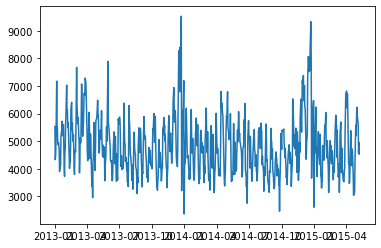

In [17]:
plt.plot(full_train.loc[full_train.Store == 1, 'Date'],full_train.loc[full_train.Store == 1,'Sales'])

## Data processing

In [18]:
train_window = 12

In [19]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw+1]
        inout_seq.append(train_seq)
    return inout_seq

In [20]:
stores = list(range(1,max(full_train.Store)))
norm_columns = ['NormSales','NormSchoolHoliday','NormPromo']
num_variables = 3

In [21]:
train_inout_seq = []
for store in stores:
    this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
    this_store_sales = this_store[norm_columns].values.astype(float)
    inout_seq = create_inout_sequences(this_store_sales,train_window)
    train_inout_seq += inout_seq

In [22]:
val_inout_seq = []
for store in stores:
    this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
    this_store_sales = this_store[norm_columns].values.astype(float)
    inout_seq = create_inout_sequences(this_store_sales,train_window)
    val_inout_seq += inout_seq

In [23]:
class SeqDataset(Dataset):
    def __init__(self, inout_seq):
        super().__init__()

        # for each sample: [:-1] is input, [-1] is target
        self.sequences = [torch.FloatTensor(i) for i in inout_seq]
    
    def __getitem__(self, i):
        sample = self.sequences[i]
        return sample

    def __len__(self):
        return len(self.sequences)
    
def batchify(list_minibatch,num_variables=num_variables):
    inp_list = [i[:-1].view(-1,num_variables) for i in list_minibatch]
    tar_list = [i[-1,0] for i in list_minibatch]

    inp_tensor = torch.stack(inp_list, dim=1)
    tar_tensor = torch.stack(tar_list, dim=0).view(-1)

    return inp_tensor, tar_tensor

In [24]:
batch_size = 1
train_dataset = SeqDataset(train_inout_seq)
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

val_dataset = SeqDataset(val_inout_seq)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)

## Models

In [25]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layers = 2, hidden_layer_size=64, dropout=0.2, output_size=1, batch_size=batch_size):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.hidden_layer_size = hidden_layer_size
        
        self.rnn = nn.RNN(input_size, hidden_layer_size, self.hidden_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        hidden = self.init_hidden()
        rnn_out, _ = self.rnn(input_seq, hidden)
        predictions = self.linear(rnn_out[-1].view(self.batch_size,-1))
        return predictions.view(-1)
    
    def init_hidden(self):
        h0 = Variable(torch.randn(self.hidden_layers, self.batch_size, self.hidden_layer_size) * 0.1)
        return h0

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layers = 2, hidden_layer_size=64, dropout=0.2, output_size=1, batch_size=batch_size):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.hidden_layer_size = hidden_layer_size
        
        self.rnn = nn.LSTM(input_size, hidden_layer_size, self.hidden_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = self.init_hidden()

    def forward(self, input_seq):
        hidden = self.init_hidden()
        rnn_out, _ = self.rnn(input_seq, hidden)
        predictions = self.linear(rnn_out[-1].view(self.batch_size,-1))
        return predictions.view(-1)
    
    def init_hidden(self):
        h0 = Variable(torch.randn(self.hidden_layers, self.batch_size, self.hidden_layer_size) * 0.1)
        c0 = Variable(torch.randn(self.hidden_layers, self.batch_size, self.hidden_layer_size) * 0.1)
        return h0, c0

In [27]:
def evaluate(model, val_data, loss_function, scaler=None, model_type = 'rnn'):
    model.eval()
    val_cache = []
    for i, batch in enumerate(val_data):
        with torch.no_grad():
            seq, labels = batch
            seq = seq.to(current_device)
            labels = labels.to(current_device)

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            val_cache.append(single_loss.item())
    avg_val = np.mean(val_cache)
    return avg_val

In [28]:
def train(model, train_data, val_data, learning_rate = 0.001, epochs = 2, train_steps = 1600, train_log_steps = 200, val_log_steps = 800, model_type = 'rnn', scaler = None):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    avg_train_cache = []
    avg_val_cache = []
    for epoch in range(epochs):
        model.train()
        train_cache = []
        for i, batch in enumerate(train_data):
            if i < train_steps:
                seq, labels = batch
                seq = seq.to(current_device)
                labels = labels.to(current_device)
                optimizer.zero_grad()
                
                y_pred = model(seq)

                single_loss = loss_function(y_pred, labels)
                train_cache.append(single_loss.item())
                single_loss.backward()
                optimizer.step()

                if i % train_log_steps == 0 and i >0:
                    avg_train_loss = np.mean(train_cache)
                    avg_train_cache.append(avg_train_loss)

                    print("Training loss at iteration {}: {:.5}".format(i,avg_train_loss))
                    train_cache = []

                if i % val_log_steps == 0 and i > 0:
                    avg_val = evaluate(model, val_data, loss_function, scaler, model_type = model_type)
                    avg_val_cache.append(avg_val)
                    print("==========Val loss at iteration {}: {:.7}".format(i,avg_val))
                    model.train()

        if len(avg_train_cache) > 0:
            print(f'epoch: {epoch:3} loss: {avg_train_cache[-1]:10.8f}')
    if len(avg_train_cache) > 0:
        print(f'epoch: {epoch:3} loss: {avg_train_cache[-1]:10.10f}')
    return model, avg_train_cache, avg_val_cache

#### Example training and testing

In [29]:
model = RNN(input_size = 3, hidden_layers = 2, hidden_layer_size=32, dropout=0.1, output_size = 1)
model.to(current_device)
model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = 0.0005, epochs=1)

Training loss at iteration 200: 0.0050742
Training loss at iteration 400: 0.0069475
Training loss at iteration 600: 0.0056318
Training loss at iteration 800: 0.0032548
==========Val loss at iteration 800: 0.003366113
Training loss at iteration 1000: 0.0026231
Training loss at iteration 1200: 0.0033095
Training loss at iteration 1400: 0.0023742
epoch:   0 loss: 0.00237418
epoch:   0 loss: 0.0023741756


Text(0.5, 1.0, 'Learning curves')

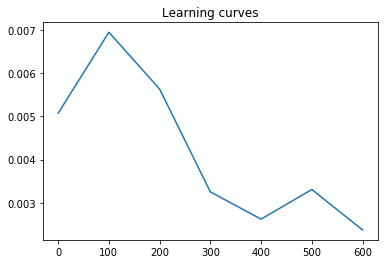

In [30]:
plt.plot(np.arange(len(avg_train_cache)) * 100, avg_train_cache,label='Avg Train')
plt.plot(np.arange(len(avg_val_cache))*300, avg_val_cache,label='Val')
plt.title('Learning curves')

In [31]:
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def rmspe(actual, predicted):
    mask = actual != 0
    return np.sqrt(np.nanmean(((actual[mask]-predicted[mask])/actual[mask])**2))

In [32]:
def full_predict(model, future_pred_window, train_window, test_actuals, test_sales, test_otherinputs = None, num_variables=1,model_type = 'rnn'):
    model.eval()

    for i in range(future_pred_window):
        sales = test_sales[i:i+train_window]
        if test_otherinputs is not None:
            inputs = test_otherinputs[i:i+train_window]
            test_data = np.concatenate((sales,inputs),axis=1)
        else:
            test_data = sales
        seq = torch.FloatTensor(test_data).view(train_window,1,num_variables).to(current_device)
        with torch.no_grad():
            test_sales = np.append(test_sales,model(seq).item()).reshape(-1,1)
    
    # add column for scaling
    test_sales_for_scaling = np.zeros((future_pred_window,len(scaler.min_)))

    test_sales_for_scaling[:,0] = test_sales[train_window:].reshape(-1)
    actual_predictions = scaler.inverse_transform(test_sales_for_scaling)[:,0]
    check = test_actuals[:future_pred_window,0]
       
    return actual_predictions, check, rmse(check, actual_predictions), rmspe(check, actual_predictions)

In [33]:
other_columns = list(set(norm_columns) - set(['NormSales']))
other_columns

['NormSchoolHoliday', 'NormPromo']

In [34]:
train_window=12
test_sales = full_train.loc[full_train.Store == 5,'NormSales'].values[-train_window:].reshape(-1,1)
test_otherinputs_train = full_train.loc[full_train.Store == 5, other_columns].values[-train_window:].reshape(-1,num_variables-1)
test_otherinputs_val = full_val.loc[full_val.Store == 5, other_columns].values.reshape(-1,num_variables-1)
test_otherinputs = np.concatenate((test_otherinputs_train, test_otherinputs_val),axis=0)
test_actuals = full_val.loc[full_val.Store == 5, 'Sales'].values.reshape(-1,1)
future_pred_window = len(test_actuals)

In [35]:
actual_predictions, test_actuals, rmse_error, rmspe_error = full_predict(model,future_pred_window, train_window, test_actuals, test_sales, test_otherinputs = test_otherinputs, num_variables=num_variables)

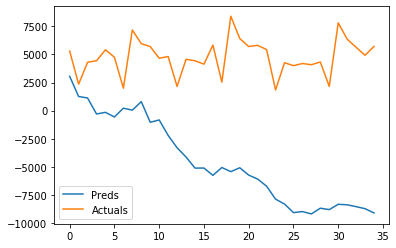

In [36]:
plt.plot(range(future_pred_window), actual_predictions, label = 'Preds')
plt.plot(range(future_pred_window),test_actuals, label = 'Actuals')
plt.legend()
plt.show()

In [37]:
test_actuals

array([5301, 2354, 4305, 4438, 5414, 4746, 1997, 7173, 5957, 5697, 4660,
       4813, 2151, 4567, 4431, 4134, 5833, 2533, 8396, 6416, 5703, 5807,
       5431, 1838, 4260, 3999, 4191, 4082, 4329, 2156, 7808, 6354, 5632,
       4924, 5711])

In [38]:
actual_predictions

array([ 3050.74440825,  1256.2147713 ,  1123.14245599,  -298.32927774,
        -153.16388018,  -567.34267186,   218.80896162,    43.36723845,
         800.32659917, -1035.57311143,  -829.13495415, -2206.03149755,
       -3304.92150337, -4128.89388829, -5113.54699725, -5107.93136138,
       -5758.87369496, -5060.18347222, -5429.29684365, -5084.71557117,
       -5735.42853045, -6088.31280643, -6722.90962845, -7874.28787738,
       -8309.63336307, -9072.76969272, -8980.79751843, -9188.94834667,
       -8681.37992829, -8806.17567867, -8332.223849  , -8378.48368686,
       -8543.48102754, -8722.66960567, -9103.59229511])

In [39]:
rmspe_error

2.3704003452370221

## Hyperparameter tuning

In [40]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]

In [41]:
dropouts = [0, 0.1,0.2]
hidden_layer_sizes = [16,32,64]
learning_rates = [0.00005, 0.0005, 0.005, 0.01]
training_windows = [4,12]
train_steps = [4800]
rnn_exogenous_options = {'best_val':10**32,
           'best_tw':0,
           'best_lr':0,
           'best_size':0,
           'best_dropout':0}

norm_columns = ['NormSales','NormSchoolHoliday','NormPromo']
num_variables = 3
rnn_history = pd.DataFrame(columns=['dropout','hidden_layer_size','learning_rate','training_window','train_steps','rmse'])

In [ ]:
for tw in training_windows:
    train_inout_seq = []
    for store in stores:
        this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
        this_store_sales = this_store[norm_columns].values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,train_window)
        train_inout_seq += inout_seq
        
    val_inout_seq = []
    for store in stores:
        this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
        this_store_sales = this_store[norm_columns].values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,train_window)
        val_inout_seq += inout_seq
        
    batch_size = 1
    train_dataset = SeqDataset(train_inout_seq)
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

    val_dataset = SeqDataset(val_inout_seq)
    val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)

    for learning_rate in learning_rates:
        for size in hidden_layer_sizes:
            for dropout in dropouts:
                for train_step in train_steps:
                    print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
                    model = RNN(input_size = num_variables, hidden_layers = 2, hidden_layer_size=size, dropout=dropout)
                    model.to(current_device)
                    loss_function = nn.MSELoss()
                    model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=1, train_steps = train_step, model_type = 'rnn', scaler = scaler)

                    avg_val = evaluate(model, val_data, loss_function, scaler, model_type = 'rnn')
                    
                    current_options = pd.DataFrame([[dropout, size, learning_rate, tw, train_step, np.sqrt(avg_val)]], columns=['dropout','hidden_layer_size','learning_rate','training_window','train_steps','rmse'])
                    rnn_history = rnn_history.append(current_options,ignore_index=True)
                    print("======================The validation RMSE is : {:.7}".format(np.sqrt(avg_val)))

                    if np.sqrt(avg_val) < rnn_exogenous_options['best_val'] :
                        rnn_exogenous_options['best_val'] = np.sqrt(avg_val)
                        rnn_exogenous_options['best_tw'] = tw
                        rnn_exogenous_options['best_lr'] = learning_rate
                        rnn_exogenous_options['best_size'] = size
                        rnn_exogenous_options['best_dropout'] = dropout
                        rnn_exogenous_options['best_trainsteps'] = train_step
                        rnn_exogenous_options['variables'] = norm_columns
                        #torch.save(model, 'best_exogenous_rnn.pt')



In [ ]:
# pkl.dump( rnn_exogenous_options, open( "rnn_exogenous_options.p", "wb" ) )
# pkl.dump( rnn_history, open( "rnn_exogenous_history.p", "wb" ) )
# rnn_exogenous_options

In [42]:
dropouts = [0, 0.1,0.2]
hidden_layer_sizes = [16,32,64]
learning_rates = [0.00005, 0.0005, 0.005, 0.01]
training_windows = [4,12]
train_steps = [4800]
lstm_exogenous_options = {'best_val':10**32,
           'best_tw':0,
           'best_lr':0,
           'best_size':0,
           'best_dropout':0}
norm_columns = ['NormSales','NormSchoolHoliday','NormPromo']
num_variables = 3
loss_function = nn.MSELoss()
lstm_history = pd.DataFrame(columns=['dropout','hidden_layer_size','learning_rate','training_window','train_steps','rmse'])

In [ ]:
for tw in training_windows:
    train_inout_seq = []
    for store in stores:
        this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
        this_store_sales = this_store[norm_columns].values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,train_window)
        train_inout_seq += inout_seq
        
    val_inout_seq = []
    for store in stores:
        this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
        this_store_sales = this_store[norm_columns].values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,train_window)
        val_inout_seq += inout_seq
        
    batch_size = 1
    train_dataset = SeqDataset(train_inout_seq)
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

    val_dataset = SeqDataset(val_inout_seq)
    val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)
    
    for learning_rate in learning_rates:
        for size in hidden_layer_sizes:
            for dropout in dropouts:
                for train_step in train_steps:
                    print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
                    model = LSTM(input_size = num_variables, hidden_layers = 2, hidden_layer_size=size, dropout=dropout)
                    model.to(current_device)
                    model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=1, train_steps = train_step, model_type='lstm', scaler = scaler)

                    avg_val = evaluate(model, val_data, loss_function, scaler, model_type='lstm')
                    current_options = pd.DataFrame([[dropout, size, learning_rate, tw, train_step, np.sqrt(avg_val)]], columns=['dropout','hidden_layer_size','learning_rate','training_window','train_steps','rmse'])
                    lstm_history = lstm_history.append(current_options,ignore_index=True)

                    print("======================The validation RMSE is : {:.5}".format(np.sqrt(avg_val)))

                    if np.sqrt(avg_val) < lstm_exogenous_options['best_val'] :
                        lstm_exogenous_options['best_val'] = np.sqrt(avg_val)
                        lstm_exogenous_options['best_tw'] = tw
                        lstm_exogenous_options['best_lr'] = learning_rate
                        lstm_exogenous_options['best_size'] = size
                        lstm_exogenous_options['best_dropout'] = dropout
                        lstm_exogenous_options['best_trainsteps'] = train_step

                        torch.save(model, 'best_exogenous_lstm.pt')



In [ ]:
# pkl.dump( lstm_exogenous_options, open( "lstm_exogenous_options.p", "wb" ) )
# pkl.dump( lstm_history, open( "lstm_exogenous_history.p", "wb" ) )

# lstm_exogenous_options

In [ ]:
# val_errors = []
# for l in range(5):
#     tw = 24
#     num_variables = 3
#     learning_rate = 0.005
#     size = 16
#     dropout = 0
#     train_steps = 4000

#     loss_function = nn.MSELoss()

#     train_inout_seq = []
#     for store in stores:
#         this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
#         this_store_sales = this_store[norm_columns].values.astype(float)
#         inout_seq = create_inout_sequences(this_store_sales,train_window)
#         train_inout_seq += inout_seq

#     val_inout_seq = []
#     for store in stores:
#         this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
#         this_store_sales = this_store[norm_columns].values.astype(float)
#         inout_seq = create_inout_sequences(this_store_sales,train_window)
#         val_inout_seq += inout_seq

#     batch_size = 1
#     train_dataset = SeqDataset(train_inout_seq)
#     train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=batchify, drop_last=False)

#     val_dataset = SeqDataset(val_inout_seq)
#     val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = batchify, drop_last=False)


#     print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
#     model = RNN(input_size=num_variables, hidden_layers = 2, hidden_layer_size=size, dropout=dropout)
#     model.to(current_device) 
#     model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=1, train_steps = train_steps, model_type='rnn', scaler = scaler)

#     avg_val = evaluate(model, val_data, loss_function, scaler, model_type='rnn')

#     print("======================The validation RMSE is : {:.5}".format(np.sqrt(avg_val)))
#     val_errors.append(np.sqrt(avg_val))
#     # torch.save(model, 'best_exogenous_rnn.pt')

# print(np.mean(val_errors))

# Evaluation

In [43]:
def full_predict(model, future_pred_window, train_window, test_actuals, test_sales, test_otherinputs = None, num_variables=1, model_type = 'rnn'):
    model.eval()

    for i in range(future_pred_window):
        sales = test_sales[i:i+train_window]
        if test_otherinputs is not None:
            inputs = test_otherinputs[i:i+train_window]
            test_data = np.concatenate((sales,inputs),axis=1)
        else:
            test_data = sales
        seq = torch.FloatTensor(test_data).view(train_window,1,num_variables).to(current_device)
        with torch.no_grad():
            test_sales = np.append(test_sales,model(seq).item()).reshape(-1,1)
    
    # add column for scaling
    test_sales_for_scaling = np.zeros((future_pred_window,len(scaler.min_)))

    test_sales_for_scaling[:,0] = test_sales[train_window:].reshape(-1)
    actual_predictions = scaler.inverse_transform(test_sales_for_scaling)[:,0]
    check = test_actuals[:future_pred_window,0]
       
    return actual_predictions, check, rmse(check, actual_predictions), rmspe(check, actual_predictions)

In [44]:
def onestep_predict(model, future_pred_window, train_window, test_actuals, test_sales, test_otherinputs = None, num_variables=1, model_type = 'rnn'):
    model.eval()
    one_step_predictions = []
    for i in range(future_pred_window):
        sales = test_sales[i:i+train_window]
        if test_otherinputs is not None:
            inputs = test_otherinputs[i:i+train_window]
            test_data = np.concatenate((sales,inputs),axis=1)
        else:
            test_data = sales        
        seq = torch.FloatTensor(test_data).view(train_window,1,num_variables).to(current_device)
        with torch.no_grad():
            one_step_predictions.append(model(seq).item())
    one_step_predictions = np.array(one_step_predictions).reshape(-1,1)
    
    # add column for scaling
    test_sales_for_scaling = np.zeros((future_pred_window,len(scaler.min_)))
    test_sales_for_scaling[:,0] = one_step_predictions.reshape(-1)
    actual_predictions = scaler.inverse_transform(test_sales_for_scaling)[:,0]
    check = test_actuals[:future_pred_window,0]
    
    return actual_predictions, check, rmse(check, actual_predictions), rmspe(check, actual_predictions)

### RNN

In [45]:
rnn_exogenous_options = pkl.load( open( "rnn_exogenous_options.p", "rb" ) )
model = torch.load('best_exogenous_rnn.pt')

loss_function = nn.MSELoss()
tw = rnn_exogenous_options['best_tw']
num_variables = len(rnn_exogenous_options['variables'])
norm_columns = rnn_exogenous_options['variables']
other_columns = list(set(norm_columns) - set(['NormSales']))

In [46]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]
store_to_plot = np.random.choice(stores,1)[0]
print("Plotting Store {}".format(store_to_plot))

future_pred_window = len(full_val.loc[full_val.Store == store_to_plot, 'NormSales'])
print("Future prediction window: {}".format(future_pred_window))

initial_test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'NormSales'].values.reshape(-1,1)
test_sales = np.append(initial_test_sales, test_actuals).reshape(-1,1)

test_otherinputs_train = full_train.loc[full_train.Store == store_to_plot, other_columns].values[-tw:].reshape(-1,num_variables-1)
test_otherinputs_val = full_val.loc[full_val.Store == store_to_plot, other_columns].values.reshape(-1,num_variables-1)
test_otherinputs = np.concatenate((test_otherinputs_train, test_otherinputs_val),axis=0)

test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values[:future_pred_window].reshape(-1,1)

Plotting Store 21
Future prediction window: 34


In [47]:
actual_predictions, check, rmse_error, rmspe_error = onestep_predict(model, future_pred_window, tw, test_actuals, test_sales, test_otherinputs = test_otherinputs, num_variables = num_variables,model_type = 'rnn')

RMSPE errror: 0.609416
RMSE errror: 2419.74


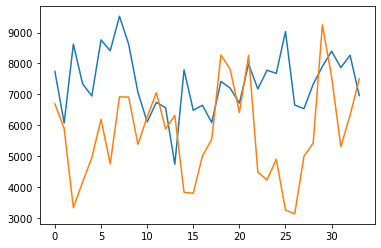

In [48]:
plt.plot(np.arange(len(actual_predictions)), actual_predictions)
plt.plot(np.arange(len(actual_predictions)), check)
print("RMSPE errror: {:.6}".format(rmspe_error))
print("RMSE errror: {:.6}".format(rmse_error))

In [49]:
initial_test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_sales = initial_test_sales.reshape(-1,1)

test_otherinputs_train = full_train.loc[full_train.Store == store_to_plot, other_columns].values[-tw:].reshape(-1,num_variables-1)
test_otherinputs_val = full_val.loc[full_val.Store == store_to_plot, other_columns].values.reshape(-1,num_variables-1)
test_otherinputs = np.concatenate((test_otherinputs_train, test_otherinputs_val),axis=0)

test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values.reshape(-1,1)
actual_predictions, check, rmse_error, mape_error = full_predict(model,future_pred_window, tw, test_actuals, test_sales, test_otherinputs = test_otherinputs, num_variables=num_variables)

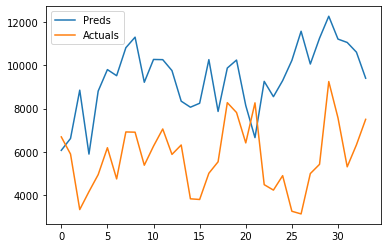

MAPE errror: 0.949618
RMSE errror: 4143.1


In [50]:
plt.plot(range(future_pred_window), actual_predictions, label = 'Preds')
plt.plot(range(future_pred_window),check, label = 'Actuals')
plt.legend()
plt.show()
print("MAPE errror: {:.6}".format(mape_error))
print("RMSE errror: {:.6}".format(rmse_error))

In [51]:
full_rmse_error = []
full_rmspe_error = []
for store in stores:
    initial_test_sales = full_train.loc[full_train.Store == store,'NormSales'].values[-tw:].reshape(-1,1)
    test_sales = initial_test_sales.reshape(-1,1)

    test_otherinputs_train = full_train.loc[full_train.Store == store, other_columns].values[-tw:].reshape(-1,num_variables-1)
    test_otherinputs_val = full_val.loc[full_val.Store == store, other_columns].values.reshape(-1,num_variables-1)
    test_otherinputs = np.concatenate((test_otherinputs_train, test_otherinputs_val),axis=0)

    test_actuals = full_val.loc[full_val.Store == store, 'Sales'].values.reshape(-1,1)
    future_pred_window = len(test_actuals)
    actual_predictions, check, rmse_error, rmspe_error = full_predict(model,future_pred_window, tw, test_actuals, test_sales, test_otherinputs = test_otherinputs, num_variables=num_variables)
    full_rmse_error.append(rmse_error)
    full_rmspe_error.append(rmspe_error)
    
print("Mean RMSE: {:.6f}".format(np.mean(full_rmse_error)))
print("Mean RMSPE: {:.6f}".format(np.mean(full_rmspe_error)))

Mean RMSE: 4794.949803
Mean RMSPE: 0.814479


### LSTM

In [52]:
lstm_options = pkl.load( open( "lstm_exogenous_options.p", "rb" ) )
model = torch.load('best_exogenous_lstm.pt')

loss_function = nn.MSELoss()
tw = rnn_exogenous_options['best_tw']
num_variables = len(rnn_exogenous_options['variables'])
norm_columns = rnn_exogenous_options['variables']

In [53]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]
store_to_plot = np.random.choice(stores,1)[0]
print("Plotting Store {}".format(store_to_plot))

future_pred_window = len(full_val.loc[full_val.Store == store_to_plot, 'NormSales'])
print("Future prediction window: {}".format(future_pred_window))

initial_test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_actuals = full_val.loc[full_val.Store == store_to_plot, 'NormSales'].values.reshape(-1,1)
test_sales = np.append(initial_test_sales, test_actuals).reshape(-1,1)

test_otherinputs_train = full_train.loc[full_train.Store == store_to_plot, other_columns].values[-tw:].reshape(-1,num_variables-1)
test_otherinputs_val = full_val.loc[full_val.Store == store_to_plot, other_columns].values.reshape(-1,num_variables-1)
test_otherinputs = np.concatenate((test_otherinputs_train, test_otherinputs_val),axis=0)

test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values[:future_pred_window].reshape(-1,1)

Plotting Store 21
Future prediction window: 34


RMSPE errror: 0.949618
RMSE errror: 12682.8


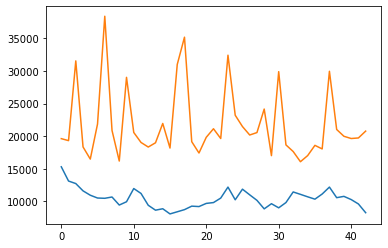

In [54]:
plt.plot(np.arange(len(actual_predictions)), actual_predictions)
plt.plot(np.arange(len(actual_predictions)), check)
print("RMSPE errror: {:.6}".format(mape_error))
print("RMSE errror: {:.6}".format(rmse_error))

In [55]:
initial_test_sales = full_train.loc[full_train.Store == store_to_plot,'NormSales'].values[-tw:].reshape(-1,1)
test_sales = initial_test_sales.reshape(-1,1)

test_otherinputs_train = full_train.loc[full_train.Store == store_to_plot, other_columns].values[-tw:].reshape(-1,num_variables-1)
test_otherinputs_val = full_val.loc[full_val.Store == store_to_plot, other_columns].values.reshape(-1,num_variables-1)
test_otherinputs = np.concatenate((test_otherinputs_train, test_otherinputs_val),axis=0)

test_actuals = full_val.loc[full_val.Store == store_to_plot, 'Sales'].values.reshape(-1,1)
actual_predictions, check, rmse_error, rmspe_error = full_predict(model,future_pred_window, tw, test_actuals, test_sales, test_otherinputs = test_otherinputs, num_variables=num_variables)

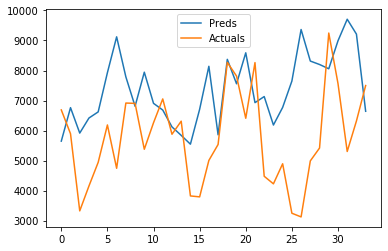

RMSPE errror: 0.589835
RMSE errror: 2416.36


In [56]:
plt.plot(range(future_pred_window), actual_predictions, label = 'Preds')
plt.plot(range(future_pred_window),check, label = 'Actuals')
plt.legend()
plt.show()
print("RMSPE errror: {:.6}".format(rmspe_error))
print("RMSE errror: {:.6}".format(rmse_error))

In [57]:
full_rmse_error = []
full_mape_error = []
for store in stores:
    initial_test_sales = full_train.loc[full_train.Store == store,'NormSales'].values[-tw:].reshape(-1,1)
    test_sales = initial_test_sales.reshape(-1,1)

    test_otherinputs_train = full_train.loc[full_train.Store == store, other_columns].values[-tw:].reshape(-1,num_variables-1)
    test_otherinputs_val = full_val.loc[full_val.Store == store, other_columns].values.reshape(-1,num_variables-1)
    test_otherinputs = np.concatenate((test_otherinputs_train, test_otherinputs_val),axis=0)

    test_actuals = full_val.loc[full_val.Store == store, 'Sales'].values.reshape(-1,1)
    future_pred_window = len(test_actuals)
    actual_predictions, check, rmse_error, mape_error = full_predict(model,future_pred_window, tw, test_actuals, test_sales, test_otherinputs = test_otherinputs, num_variables=num_variables)
    full_rmse_error.append(rmse_error)
    full_mape_error.append(mape_error)
    
print("Mean RMSE: {:.6f}".format(np.mean(full_rmse_error)))
print("Mean MAPE: {:.6f}".format(np.mean(full_mape_error)))

Mean RMSE: 3808.510975
Mean MAPE: 0.532629


# Store subset

In [ ]:
stores = [1,2,3,4,5,13,15,18,21,85,259,262]
tw = 12

norm_columns = ['NormSales', 'NormYear','NormMonth','NormDay','NormDayOfWeek','NormWeekOfYear', 'NormPromo','NormSchoolHoliday']
other_columns = list(set(norm_columns) - set(['NormSales']))

num_variables = len(norm_columns)
learning_rate = 0.00005
dropout = 0.1
num_layers = 2

size = 32
num_epochs = 10
val_steps = 1000
train_log_steps = 600

full_rmse_error = []
full_rmspe_error = []

for the_store in stores:
    these_stores = [the_store]
    print("Loading train data")
    train_inout_seq = []
    for store in these_stores:
        this_store = full_train.loc[full_train.Store == store].sort_values(by='Date')
        this_store_sales = this_store[norm_columns].values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,tw)
        train_inout_seq += inout_seq

    print("Loading val data")
    val_inout_seq = []
    for store in these_stores:
        this_store = full_val.loc[full_val.Store == store].sort_values(by='Date')
        this_store_sales = this_store[norm_columns].values.astype(float)
        inout_seq = create_inout_sequences(this_store_sales,tw)
        val_inout_seq += inout_seq

    batch_size = 1
    train_dataset = SeqDataset(train_inout_seq)
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda b: batchify(b,num_variables), drop_last=False)

    val_dataset = SeqDataset(val_inout_seq)
    val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = lambda b: batchify(b,num_variables), drop_last=False)

    print("Running model with training window size: {}\n learning rate: {}\n hidden size: {}\n dropout: {}\n\n".format(tw,learning_rate, size, dropout))
    model = LSTM(input_size = num_variables, hidden_layers = num_layers, hidden_layer_size=size, dropout=dropout, output_size = 1)
    model.to(current_device)
    model, avg_train_cache, avg_val_cache = train(model,train_data, val_data, learning_rate = learning_rate, epochs=num_epochs, train_log_steps = train_log_steps, val_log_steps = val_steps, train_steps = 4000, model_type='lstm', scaler = None)

    avg_val = evaluate(model, val_data, loss_function, scaler, model_type='lstm')
    initial_test_sales = full_val.loc[full_val.Store == the_store,'NormSales'].values[-tw:].reshape(-1,1)
    test_sales = initial_test_sales.reshape(-1,1)
    
    test_otherinputs_train = full_val.loc[full_val.Store == the_store, other_columns].values[-tw:].reshape(-1,num_variables-1)
    test_otherinputs_val = full_test.loc[full_test.Store == the_store, other_columns].values.reshape(-1,num_variables-1)
    test_otherinputs = np.concatenate((test_otherinputs_train, test_otherinputs_val),axis=0)

    test_actuals = full_test.loc[full_test.Store == the_store, 'Sales'].values.reshape(-1,1)
    future_pred_window = len(test_actuals)
    
    actual_predictions, check, rmse_error, rmspe_error = full_predict(model,future_pred_window, tw, test_actuals, test_sales, test_otherinputs = test_otherinputs, num_variables=num_variables)
    full_rmse_error.append(rmse_error)
    full_rmspe_error.append(rmspe_error)
    
print("Mean RMSE: {:.6f}".format(np.mean(full_rmse_error)))
print("Mean RMSPE: {:.6f}".format(np.mean(full_rmspe_error)))